# Using low number of field images to build a powerful image classification

In this project, I will be presenting simple yet effective method to build a powerful image classifier, using only very few training examples (in my case few hundreds pictures) from each class you want to identify.

## Introduction

The human brain can easily recognize and distinguish the objects in an image, for instance, we distinguish two buildings and our brain perceives this difference.  
Machines can easily distinguish between different images, detect objects and faces. Classifications is one of the interesting topics of Computer Vision, as it is the ability of a machine to distinguish between objects.

Image classification has been further accelerated by the advent of Transfer Learning [Reference Link](https://machinelearningmastery.com/transfer-learning-for-deep-learning/). In simple words, Transfer learning allows us to use a pre-existing model, already trained on a huge dataset, for our own tasks. 

Consequently reducing the cost of training new deep learning models and since the datasets have been vetted, we can be assured of the quality.

In our case, we will be using Imagenet [Reference Link](https://image-net.org/download) 
which is dataset of over 14 million images belonging to 1000 classes. 

## Data Collection

For this step, I have collected around 1620 images for 3 buildings using my mobile phone. The average size of each photo is 3MB. The photos have been divided equally for each, and the respective folders have been creates as follows:
    Train: 417 Images for each building 
    Validation: 100 Images for each building
    Test: 20 Images for each building.
    
You can check the folder of HU images in the link below

https://drive.google.com/drive/folders/1f28A64w9g_L-nFNj3ovehWyq25dG7mXk?usp=sharing

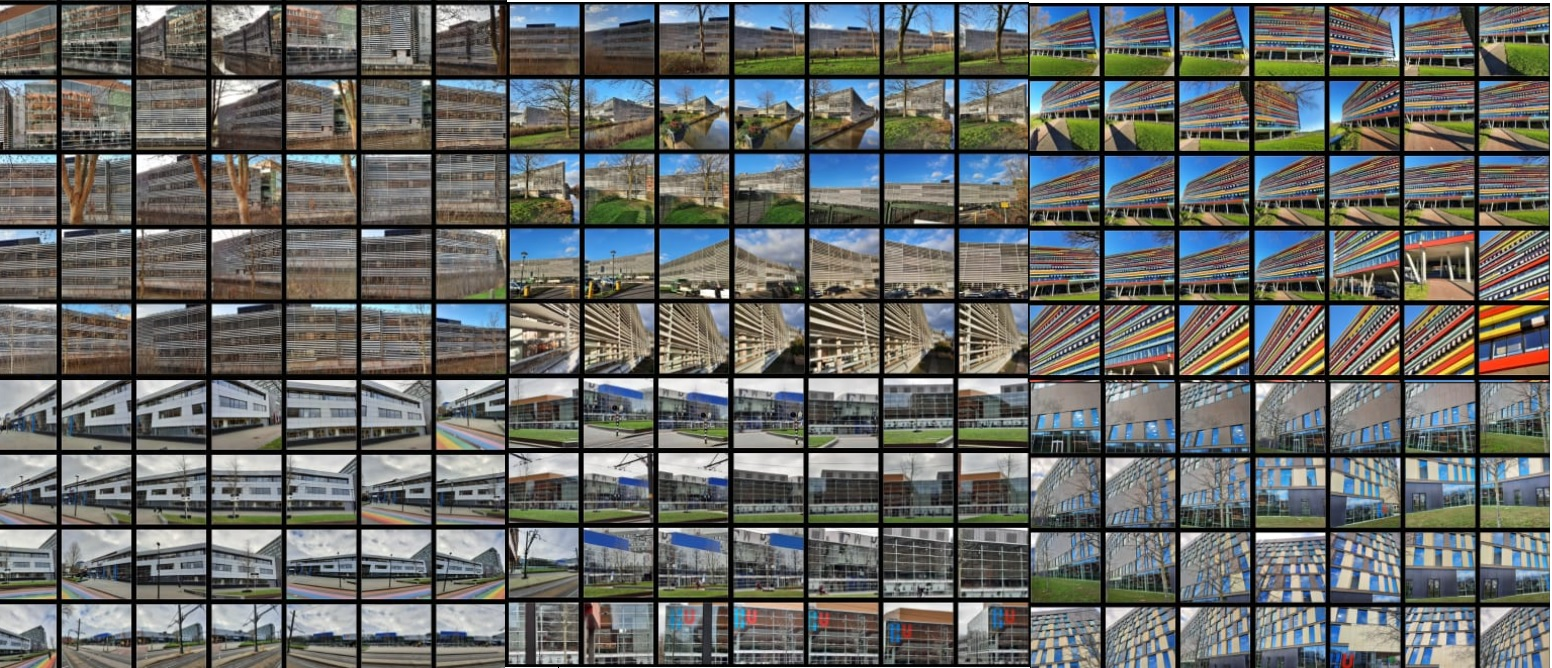


We can check the GPUs available, we have the A100 with 40GB Memory

In case the Colab is used with default GPUs, we can connect to the below drive. I was also using a local runtime to utilize the A100 GPUs, which I had to upload again the photos folder to that machine.

In [ ]:
!nvidia-smi

Tue Jan 25 12:10:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive #Only if you are using Google Drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/My\ Drive/

In [ ]:
cd FML_Final/

In [ ]:
%tensorflow_version  1.x

Loading the datasets. There are three main folders: Train for training the data, Validation to test the trained data and get the needed accuracy (Test in our concept), and there is the Test data, which is what we present to the system to make the predications (images that it has never seen before). Below is the folder layout, you can do the same for any class, in our case we have 3 classes (representing 3 Campus Buildings) and putting the building images in the respective folders.




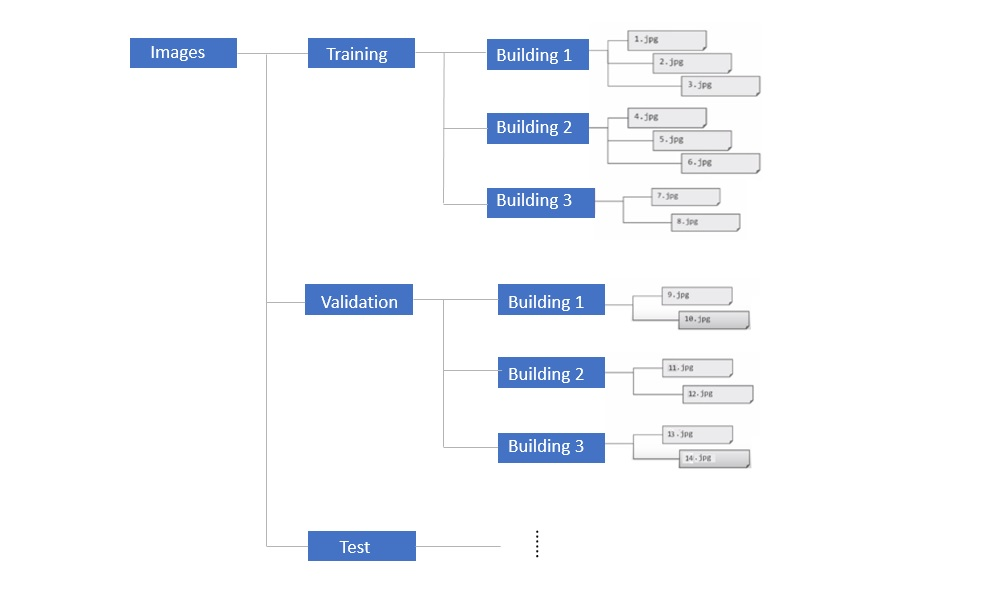


## The Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

training_dir = './dataset2/Train/' #Define the directory of each
validation_dir = './dataset2/Validation/'
test_dir = './dataset2/Test'

folders = glob(training_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 3


The above 3 classes belong to the number of buildings of HU (3 buildings) as shown below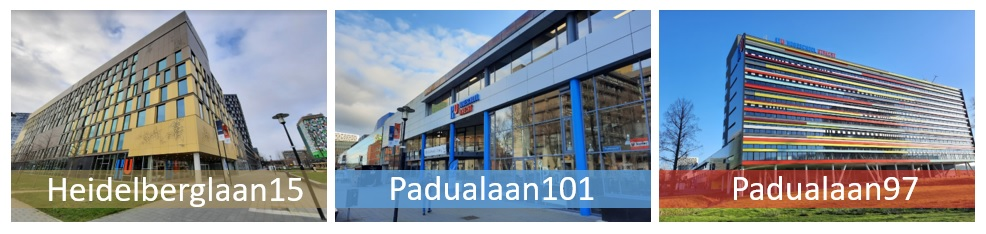

Below we will be loading and finetunning the VGG16 model. 
It is referred to Very Deep Convolutional Networks for Large-Scale Image Recognition(VGG-16). The VGG-16 is one of the most popular pre-trained models for image classification [link to paper](https://arxiv.org/abs/1409.1556). Below is the VGG-16 architecture. The 16 in VGG16 refers to it has 16 layers that have weights. 

In this attempt we will resize the Images to 224x224 using the pretrained weights of Imagenet. This is the recommended image dimension although we have started with relatively small image dimension sizes.We have played around with different image dimensions which we described in Appendix A 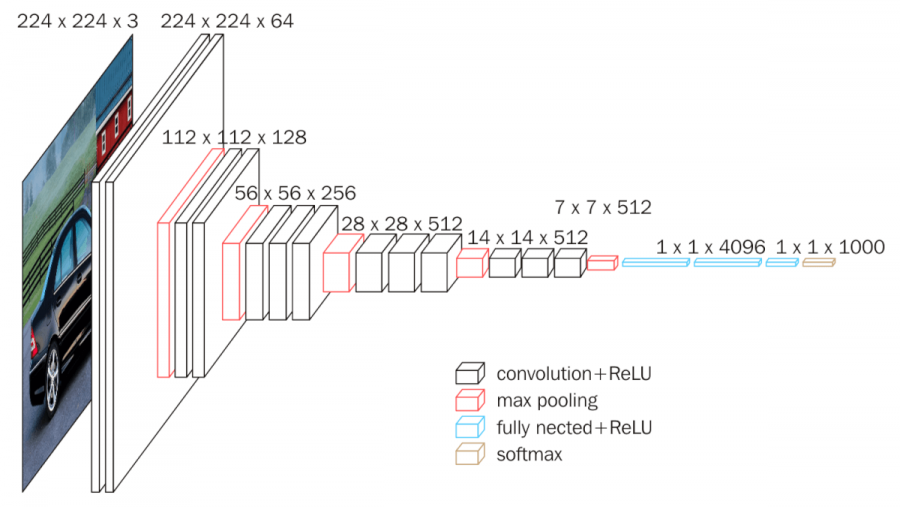

[1]  [Image Reference](httphttps://miro.medium.com/max/1050/0*0M8CobXpNwFDCmOQs://)

Now let us now import the respective libraries from TensorFlow.
As mentioned, we will resize the image size to 224x224

In [ ]:
# importing the libraries
from keras import applications
from keras.models import Model
import keras 
from keras.applications.vgg16 import VGG16 #Importing the VGG16 Model
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from keras.applications import VGG16, MobileNetV2
from keras.optimizers import SGD
import tensorflow as tf

#Loading VGG16 Model
IMAGE_SIZE = [224,224]   

vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  #we use the Include_top=False to remove the classification 
#layer that was trained on the ImageNet dataset and set the model as not trainable

for layer in vgg.layers:
      layer.trainable = False # Non trainable weights


x = Flatten()(vgg.output) #We add the last layers (Flatten and Dense layers) for our problem
x = Dense(num_classes, activation = 'softmax')(x) #After creating all the convolution I pass the data to the dense layer to flatten the vector which comes out of the convolutions (Refer to VGG16 image dimention layers above)

model = Model(inputs = vgg.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #I need to compile them model, for this we will be using ADAM optimiser to reach to the global minima while training our model
model.summary() #check summary of the model using this command


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________

As seen above, the model has over 14 Million trained parameters and ends with a maxpooling layer, that belongs to the Feature Learning part of the network, and the last two are the ones we added (flattened and dense layers). 

Now let us compile and fit the model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 

#Here I have imported ImageDataGenerator from keras.preprocessing. The objective of ImageDataGenerator is to import data with labels easily 
#into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc. The most useful thing about this 
#class is that it doesn’t affect the data stored on the disk. This class alters the data on the go while passing it to the model.

from keras.applications.vgg16 import preprocess_input # we use the preprocess_input function from VGG16 to normalize the input data

training_datagen = ImageDataGenerator(
                                    rescale=1./255,   
                                    shear_range= 0.2,# In this we are applying Shear transformations for images to enhance the training >> https://en.wikipedia.org/wiki/Shear_mapping 
                                    zoom_range= 0.2,# Here we are applying the zooming of images for the same reason  
                                    horizontal_flip=True, #Here we are flipping the images to further enhance the training
                                    preprocessing_function=preprocess_input)
#Above we are doing the Data Augmentation, which will prove to be very useful to increase the amount of training (or even validation) data by providing additional flavors of our images

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(training_dir, target_size = IMAGE_SIZE, batch_size = 255, class_mode = 'categorical') #In this attempt, I am increasing the batch size to 255 in both training and validation
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = IMAGE_SIZE, batch_size = 255, class_mode = 'categorical')
training_generator.class_indices


Found 1250 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


{'Heidelberglaan15': 0, 'Padualaan101': 1, 'Padualaan97': 2}

As shown from the data results above, we have 1250 images for training the data (approximately 418 images for each building), and 300 images for testing (in our case validation), so for each class we have 100 images. 

approximately the split is around 75% Training and 25% validation.

The softmax layer will output the value of 0, 1, or 2 based on the confidence of the model, as per which class the images belongs to. Each output refers to one of our building names

Next we will be running the training and saving the model as we will be conducting several tweeks of the model, and we don't want to lose the parameters for each.

Below you can change the number of epocs for each training. 

Detailed information for all project attempts to increase accuracy and decrease loss, while having better predictions over time is found in the **Appendix A**: Evolution of Attempts. 

 

*   Attempt 1: Started with 20 epocs, image dimension 32x32 , batch size 16, default parameters 
*   Attempt 2: Tried working with 40 epocs, same image dimension 32x32 , same batch size 16, default parameters 
*   Attempt 3: Increased to 100 epocs, increased image dimension 64x64 , same batch size 16, default parameters
*   Attempt 4: Worked with 10 epocs only for an image dimension of 224x224 (Default VGG16 Model) , increased batch size 255, default parameters
*  Attempt 5: Worked with 10 epocs only, same image dimension of 224x224 (Default VGG16 Model) , batch size 255, added the shear and zoom range parameters


For now we will show the steps for the last attempt, Attempt 5,  as shown below. 

In [ ]:
history = model.fit_generator(training_generator,
                   steps_per_epoch = 5, #Number of iterations = number of training images / batch size (255)  
                   epochs = 10, 
                   validation_data = validation_generator,
                   validation_steps = 2, #same for validation data 300 validation images
                   shuffle = True) 
model.save('A_100_vgg16_v10e_255_Param.h5')


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)
2022-01-25 12:12:39.589644: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-01-25 12:12:40.967034: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8


2/5 [===========>..................] - ETA: 5:08 - loss: 1.5765 - accuracy: 0.3918 

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


4/5 [=======================>......] - ETA: 1:13 - loss: 1.5568 - accuracy: 0.4533

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


5/5 [==============================] - 380s 76s/step - loss: 1.4124 - accuracy: 0.4760 - val_loss: 1.3203 - val_accuracy: 0.4067
Epoch 2/10


/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


2/5 [===========>..................] - ETA: 2:44 - loss: 0.9939 - accuracy: 0.5235

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


5/5 [==============================] - 298s 60s/step - loss: 0.7307 - accuracy: 0.6696 - val_loss: 0.7046 - val_accuracy: 0.7033
Epoch 3/10
5/5 [==============================] - 298s 60s/step - loss: 0.4296 - accuracy: 0.8240 - val_loss: 0.6006 - val_accuracy: 0.8467
Epoch 4/10
5/5 [==============================] - 298s 60s/step - loss: 0.3005 - accuracy: 0.8848 - val_loss: 0.1912 - val_accuracy: 0.9067
Epoch 5/10
5/5 [==============================] - 299s 60s/step - loss: 0.2330 - accuracy: 0.9128 - val_loss: 0.2094 - val_accuracy: 0.9467
Epoch 6/10
5/5 [==============================] - 298s 60s/step - loss: 0.1667 - accuracy: 0.9408 - val_loss: 0.1722 - val_accuracy: 0.9333
Epoch 7/10
5/5 [==============================] - 298s 60s/step - loss: 0.1471 - accuracy: 0.9456 - val_loss: 0.1125 - val_accuracy: 0.9500
Epoch 8/10
5/5 [==============================] - 299s 60s/step - loss: 0.1172 - accuracy: 0.9616 - val_loss: 0.0991 - val_accuracy: 0.9533
Epoch 9/10
5/5 [===============

Above reading show the training and validation losses and accuracies.
The training accuracy in this Attempt is 97% with validation accuracy 96%. The training loss has decreased significantly in just 10 eposc (0.09)

If you want to load the saved model, use the below command (file name should be found on your main folder with .h5 extension)

In [ ]:
from keras.models import load_model
model = load_model('A_100_vgg16_v10e_255_Param.h5')

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall #Sometimes the above makes error, use this command only if the above made an error


## Testing the Model

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os
img_size = 224
clssN = ['Heidelberglaan15','Padualaan101','Padualaan97']
count = 0
countT = 0
for bl in clssN:
  src = './dataset2/Test/' + bl 
  imgs = os.listdir(src)
  count = 0
  countT = len(imgs) #total number of images per class
  for img in imgs: 
    im = load_img(src + "/" + img)
    w,h = im.size
    im = im.resize((int(w*0.2),int(h*0.2)))
    im = im.resize((img_size,img_size))
    x = img_to_array(im)  
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x/=255.
    probs = model.predict(x, verbose=0)
    maxDet = max(probs[0])
    maxIdx = list(probs[0]).index(maxDet) #predicted class with maximum probability
    if (clssN[maxIdx]==bl): 
      count = count + 1  #count for true predictions (true positives)
    else:
      print(f'Wrong prediction of {bl}  {img}. Predicted as {clssN[maxIdx]}') 
  print(f'test accuracy for {bl} is {str(count/countT)}')

test accuracy for Heidelberglaan15 is 1.0
Wrong prediction of Padualaan101  20211220_142909.jpg. Predicted as Padualaan97
test accuracy for Padualaan101 is 0.95
test accuracy for Padualaan97 is 1.0


Test accuracy is 1 for both Heidelberglaan15 and Padualaan97 buildings, 
this means it predicted the 20 test building(100% Test images) correctly for each of those class. Only one image it got it wrong for Padualaan 101 as per below: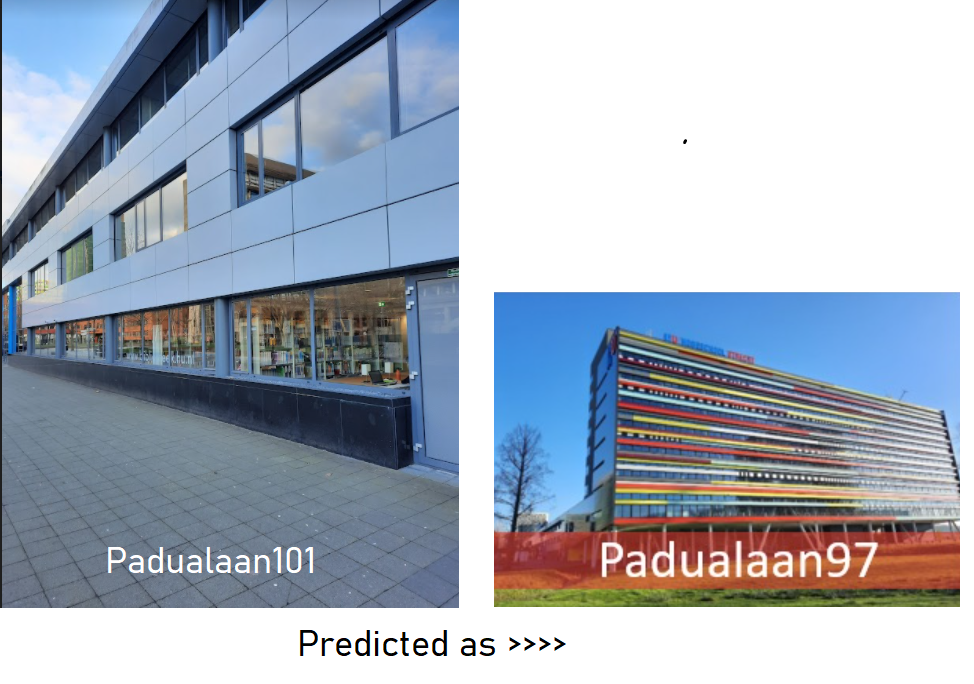

I made a quick way to test any image we have for those buildings, and check its respective class. Just take a photo and place its correct path folder below. Using the below code, you will see the output of what building class the model has predicted for this specific image.

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os
img_size = 224
clssN = ['Heidelberglaan15','Padualaan101','Padualaan97']
imgDir = "dataset2/Test/Padualaan101/20211220_121005.jpg"
im = load_img(imgDir)
w,h = im.size
im = im.resize((int(w*0.2),int(h*0.2)))
im = im.resize((img_size,img_size))
x = img_to_array(im)  
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x/=255.
probs = model.predict(x, verbose=0)
maxDet = max(probs[0])
maxIdx = list(probs[0]).index(maxDet) #predicted class with maximum probability
print(clssN[maxIdx])

Padualaan101




## Plotting Loss and Accuracy

Plotting the loss and accuracy of the model while training. We will be passing the output of mode.fit_generator to history variable (defined above). All the training/validation accuracy and loss are stored in hist and we will visualise it from there.

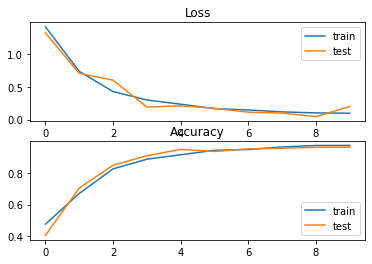

In [ ]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

As shown above, with only 10 epocs, we reached traing and validation loss less than 0.1, and accuracy of 97%. The model is now trained not to make the mistakes it was doing on the first attempts (20 and 40 epocs further compared below in **Appendix A**), due to larger image size (taking more data pixels from original image) and increasing the batch size to 255. We cannot say if the the shear and zoom range parameters made a difference here, as the wrong prediction was with one image only. Maybe if we had more images to test then we could know their effect on accuracy. Model is much faster trained (52minutes compared to 7 hours on 100 epocs of 16 batch images)   

Saving the trained model history configurations, as sometime the graphs above lose the history of variables, there will created a new file (.pkl) to load those again.


In [ ]:
import pickle
with open("histA_100_vgg16_v10e_255_Param.pkl", "wb") as output_file:
   pickle.dump(history, output_file)

In [ ]:
from keras.models import load_model
model = load_model('A_100_vgg16_v10e_255_Param.h5')

When using the image classification in different applications (Like intergating this with mobile), it is needed to save a smaller version of the model (Quantizing the trained model) to obtain a more compact model representation, and the use of high performance vectorized operations on many hardware platforms. In our case, we have saved a quantized version for model compression and latency reduction in case we used it in mobile app. 

*   Current model size: A_100_vgg16_v10e_255_Param.h5 is 58.4 MB
*   Quantized model size: A_100_vgg16_q_v10e_255_Param.tflite is 14.4MB (only 24% of original model size)



Below is how to load the quantized model (save in the same folder)

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model_file("A_100_vgg16_v10e_255_Param.h5")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
open("A_100_vgg16_q_v10e_255_Param.tflite", "wb").write(tflite_quantized_model)

2022-01-25 13:10:12.755862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: A100-SXM4-40GB major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:00:04.0
2022-01-25 13:10:12.756000: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-01-25 13:10:12.756041: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-01-25 13:10:12.756056: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-01-25 13:10:12.756070: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2022-01-25 13:10:12.756082: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusolver.so.10
2022-01-25 13:10:12.756094: I tensorflow/stream_executor/platform/defa

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 28 variables.
INFO:tensorflow:Converted 28 variables to const ops.


2022-01-25 13:10:13.184131: I tensorflow/core/grappler/devices.cc:55] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-01-25 13:10:13.184300: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-01-25 13:10:13.185681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: A100-SXM4-40GB major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:00:04.0
2022-01-25 13:10:13.185740: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-01-25 13:10:13.185768: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-01-25 13:10:13.185779: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-01-25 13:10:13.185789: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opene

14808896



```
# This is formatted as code
```

## **Appendix A**: Evolution of Attempts

The above was the final iteration (Attempt 5) that we used its below mentioned parameters. Before that we have started with lower image resolution, lower epocs, and recorded the performance for each. I am summarizing the findings of 5 attempts made for this project in the below table. Lets go with them one by one

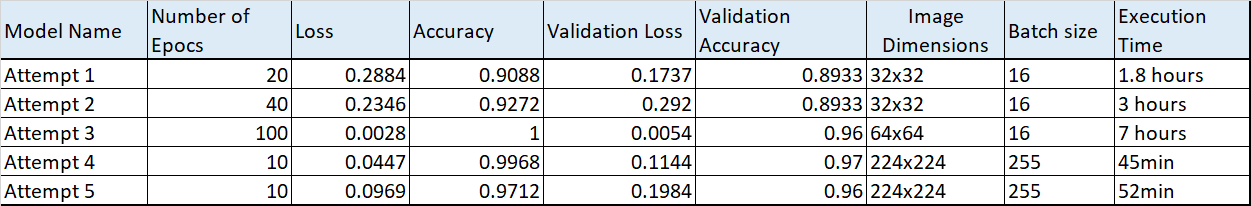

**Attempts 1 and 2**: Using 32x32 image size, 16 batch size. This was used to make use of the fee Colab GPUs already offered, which gives a limitation of time for training to complete it before 4 hours (limitation of Free Colab version). Attempt 1 used 20 epocs, and Attempt 2 used 40 epocs. We wanted to check how doubling the number of epocs will effect the performance keeping size images and batch sizes low.

In [ ]:
# importing the libraries
from keras import applications
from keras.models import Model
import keras 
from keras.applications.vgg16 import VGG16 
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from keras.applications import VGG16, MobileNetV2
from keras.optimizers import SGD
import tensorflow as tf


IMAGE_SIZE = [32,32]   

vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  

for layer in vgg.layers:
      layer.trainable = False

#x = Dropout(0.25)(vgg.output)
x = Flatten()(vgg.output)
x = Dense(num_classes, activation = 'softmax')(x) #After creating all the convolution I pass the data to the dense layer to flatten the vector which comes out of the convolutions (Refer to VGG16 image dimention layers above)

model = Model(inputs = vgg.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

training_datagen = ImageDataGenerator(
                                    rescale=1./255,   
                                    shear_range= 0.0,
                                    zoom_range= 0.0,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(training_dir, target_size = IMAGE_SIZE, batch_size = 16, class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = IMAGE_SIZE, batch_size = 16, class_mode = 'categorical')
training_generator.class_indices


Found 1250 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


{'Heidelberglaan15': 0, 'Padualaan101': 1, 'Padualaan97': 2}

In [ ]:
history = model.fit_generator(training_generator,
                   steps_per_epoch = 79, #Number of iterations = number of training images / batch size (16)  
                   epochs = 40, 
                   validation_data = validation_generator,
                   validation_steps = 19, #same for validation data 300 validation images
                   shuffle = True) 
model.save('v_100_vgg16_v40e.h5')


Epoch 1/40
79/79 [==============================] - 929s 12s/step - loss: 0.9165 - accuracy: 0.6080 - val_loss: 0.6290 - val_accuracy: 0.7533
Epoch 2/40
79/79 [==============================] - 254s 3s/step - loss: 0.6420 - accuracy: 0.8016 - val_loss: 0.8322 - val_accuracy: 0.7767
Epoch 3/40
79/79 [==============================] - 259s 3s/step - loss: 0.5762 - accuracy: 0.8160 - val_loss: 0.6926 - val_accuracy: 0.8033
Epoch 4/40
79/79 [==============================] - 258s 3s/step - loss: 0.5139 - accuracy: 0.8312 - val_loss: 0.4745 - val_accuracy: 0.8067
Epoch 5/40
79/79 [==============================] - 259s 3s/step - loss: 0.4758 - accuracy: 0.8408 - val_loss: 0.4340 - val_accuracy: 0.8100
Epoch 6/40
79/79 [==============================] - 258s 3s/step - loss: 0.4593 - accuracy: 0.8432 - val_loss: 0.3560 - val_accuracy: 0.8000
Epoch 7/40
79/79 [==============================] - 258s 3s/step - loss: 0.4298 - accuracy: 0.8568 - val_loss: 0.6083 - val_accuracy: 0.8200
Epoch 8/40


Loss is still high, and the accuracy is relatively low. Now let us check the performance of classification 

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os
img_size = 32
clssN = ['Heidelberglaan15','Padualaan101','Padualaan97']
count = 0
countT = 0
for bl in clssN:
  src = './dataset2/Test/' + bl 
  imgs = os.listdir(src)
  count = 0
  countT = len(imgs) #total number of images per class
  for img in imgs: 
    im = load_img(src + "/" + img)
    w,h = im.size
    im = im.resize((int(w*0.2),int(h*0.2)))
    im = im.resize((img_size,img_size))
    x = img_to_array(im)  
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x/=255.
    probs = model.predict(x, verbose=0)
    maxDet = max(probs[0])
    maxIdx = list(probs[0]).index(maxDet) #predicted class with maximum probability
    if (clssN[maxIdx]==bl): 
      count = count + 1  #count for true predictions (true positives)
    else:
      print(f'Wrong prediction of {bl}  {img}. Predicted as {clssN[maxIdx]}') 
  print(f'test accuracy for {bl} is {str(count/countT)}')





*   test accuracy for Heidelberglaan15 is 1.0

*   Wrong prediction of Padualaan101  20211220_120839.jpg. Predicted as Heidelberglaan15. test accuracy for Padualaan101 is 0.95

*   Wrong prediction of Padualaan97  20211221_134311.jpg. Predicted as Padualaan101
Wrong prediction of Padualaan97  20211221_134436.jpg. Predicted as Padualaan101
Wrong prediction of Padualaan97  20211221_134821.jpg. Predicted as Padualaan101
Wrong prediction of Padualaan97  20211221_134841(0).jpg. Predicted as Padualaan101
test accuracy for Padualaan97 is 0.75






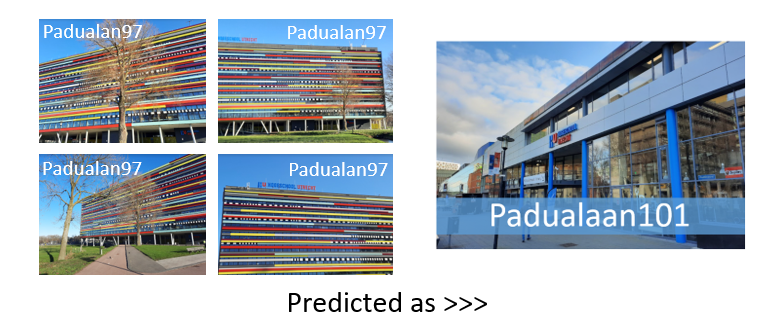

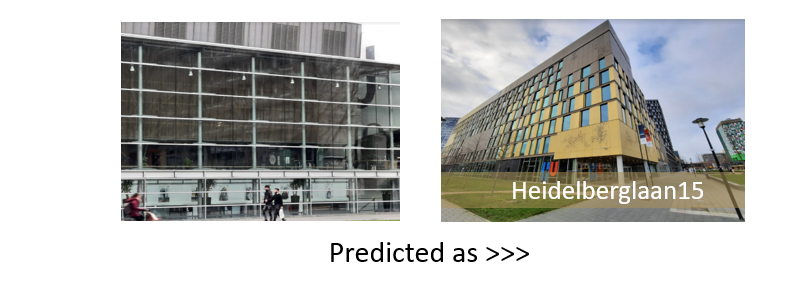

As seen above, the prediction is not accurate. For one building it is having test accuracy of less than 75% which should be enhanced.
It is noticed that the trees are found in the test samples where it got the prediction wrong. My assumption is that there are lots of trees in the training data that could create this bias. In addition, the size of the images are relatively low (32x32) and we are loosing lots of data from the original images, even compared to the standard VGG16 model resoutions (224x224).

A quick plotting of the loss and accuracy shows how poorly the prediction was performing.

In [ ]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

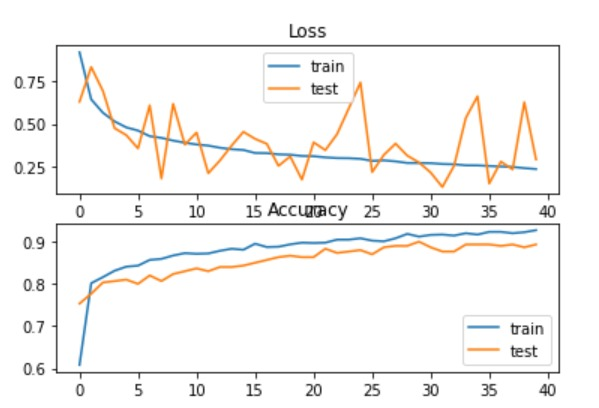

We are barely reaching the 90% accuracy, and the loss is relatively high, and this is evident in the wrong predictions of some sample test images.

**Attempt 3:** Now let us try to increase the image dimension to 64x64, and now use 100 epocs. Luckily we will be using now a more powerful GPU as this can take some time to train. We will be working with the A100 GPUs with 40 GB Memory

In [ ]:
!nvidia-smi

Sat Jan 22 12:50:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    51W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# importing the libraries
from keras import applications
from keras.models import Model
import keras 
from keras.applications.vgg16 import VGG16 
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from keras.applications import VGG16, MobileNetV2
from keras.optimizers import SGD
import tensorflow as tf


IMAGE_SIZE = [64,64]   

vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  

for layer in vgg.layers:
      layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(num_classes, activation = 'softmax')(x) 

model = Model(inputs = vgg.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

training_datagen = ImageDataGenerator(
                                    rescale=1./255,   
                                    shear_range= 0.0,
                                    zoom_range= 0.0,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(training_dir, target_size = IMAGE_SIZE, batch_size = 16, class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = IMAGE_SIZE, batch_size = 16, class_mode = 'categorical')
training_generator.class_indices


Found 1250 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


{'Heidelberglaan15': 0, 'Padualaan101': 1, 'Padualaan97': 2}

In [ ]:
history = model.fit_generator(training_generator,
                   steps_per_epoch = 79, #Number of iterations = number of training images / batch size (16)  
                   epochs = 100, 
                   validation_data = validation_generator,
                   validation_steps = 19, #same for validation data 300 validation images
                   shuffle = True) 
model.save('v_100_vgg16_v100e.h5')


Epoch 1/100


2022-01-22 12:57:15.812237: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-01-22 12:57:17.030444: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8


79/79 [==============================] - 319s 4s/step - loss: 0.6008 - accuracy: 0.7672 - val_loss: 0.4872 - val_accuracy: 0.8767
Epoch 2/100
79/79 [==============================] - 252s 3s/step - loss: 0.3345 - accuracy: 0.8976 - val_loss: 0.3626 - val_accuracy: 0.9000
Epoch 3/100
79/79 [==============================] - 254s 3s/step - loss: 0.2675 - accuracy: 0.9168 - val_loss: 0.3064 - val_accuracy: 0.9067
Epoch 4/100
79/79 [==============================] - 253s 3s/step - loss: 0.2197 - accuracy: 0.9336 - val_loss: 0.1252 - val_accuracy: 0.9200
Epoch 5/100
79/79 [==============================] - 264s 3s/step - loss: 0.2016 - accuracy: 0.9408 - val_loss: 0.5305 - val_accuracy: 0.9167
Epoch 6/100
79/79 [==============================] - 252s 3s/step - loss: 0.1763 - accuracy: 0.9456 - val_loss: 0.1448 - val_accuracy: 0.9200
Epoch 7/100
79/79 [==============================] - 252s 3s/step - loss: 0.1569 - accuracy: 0.9560 - val_loss: 0.0596 - val_accuracy: 0.9267
Epoch 8/100
79/79 

This took a lot of time, hoping we increased the accuracy. Unfortunately, after epoc 48 we are not having significant enhancement in the accuracy, I believe we are reaching here overfitting although the accuracy is 96% and the loss is significantly low (lowest 0.005). But how about the prediction now of the testing images? lets see:

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os
img_size = 64
clssN = ['Heidelberglaan15','Padualaan101','Padualaan97']
count = 0
countT = 0
for bl in clssN:
  src = './dataset2/Test/' + bl 
  imgs = os.listdir(src)
  count = 0
  countT = len(imgs) #total number of images per class
  for img in imgs: 
    im = load_img(src + "/" + img)
    w,h = im.size
    im = im.resize((int(w*0.2),int(h*0.2)))
    im = im.resize((img_size,img_size))
    x = img_to_array(im)  
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x/=255.
    probs = model.predict(x, verbose=0)
    maxDet = max(probs[0])
    maxIdx = list(probs[0]).index(maxDet) #predicted class with maximum probability
    if (clssN[maxIdx]==bl): 
      count = count + 1  #count for true predictions (true positives)
    else:
      print(f'Wrong prediction of {bl}  {img}. Predicted as {clssN[maxIdx]}') 
  print(f'test accuracy for {bl} is {str(count/countT)}')

Wrong prediction of Heidelberglaan15  20211220_114434.jpg. Predicted as Padualaan97
Wrong prediction of Heidelberglaan15  20211220_113605.jpg. Predicted as Padualaan97
Wrong prediction of Heidelberglaan15  20211220_113115.jpg. Predicted as Padualaan97
test accuracy for Heidelberglaan15 is 0.85
Wrong prediction of Padualaan101  20211220_142909.jpg. Predicted as Padualaan97
Wrong prediction of Padualaan101  20211220_143154.jpg. Predicted as Heidelberglaan15
test accuracy for Padualaan101 is 0.9
test accuracy for Padualaan97 is 1.0


As expected, we most probably had overfitting, since the accuracy numbers are very high, but the model is not predicting the ones it correctly predicted in Attempts 1 and 2. Let us see which are those pictures: 

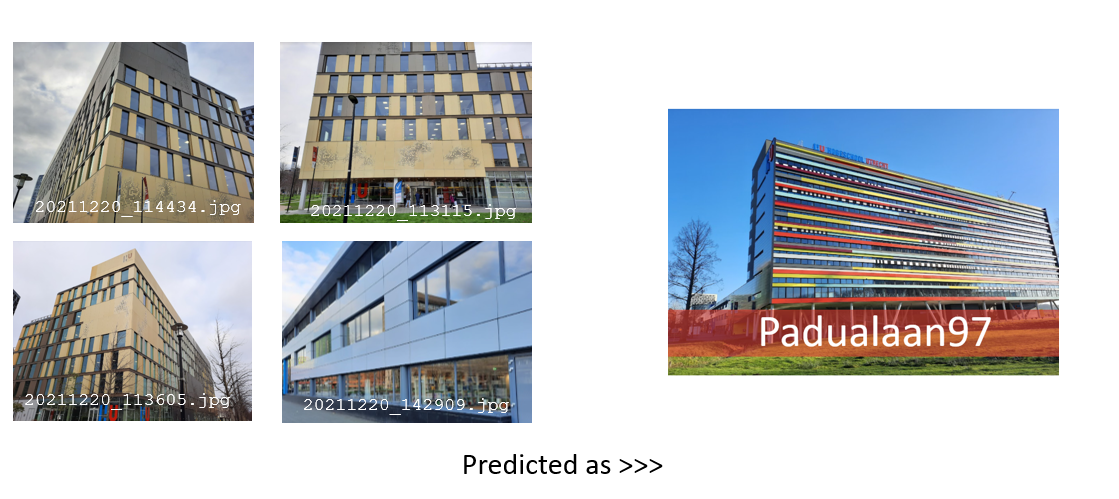

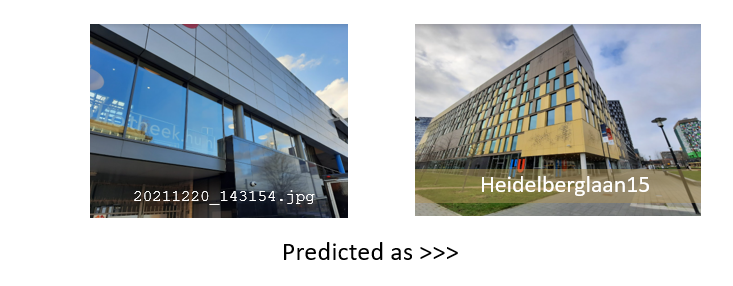

Even what it predicted correctly in the first two attempts, it got them wrong in this one.

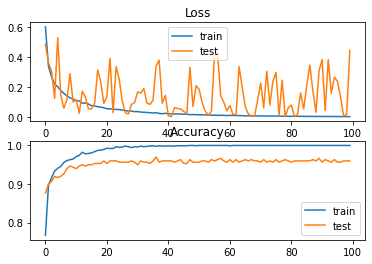

In [ ]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()





> Indented block



**Attempt 4:** Now since we have access to good GPUs, let us try to increase the image dimension to the default VGG16 which is 224x224, and now use much lower epocs (10). We will increase the batch size significantly this time, till 255, to try to make the overall process faster. Lets see what happens

In [ ]:
# importing the libraries
from keras import applications
from keras.models import Model
import keras 
from keras.applications.vgg16 import VGG16 
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from keras.applications import VGG16, MobileNetV2
from keras.optimizers import SGD
import tensorflow as tf


IMAGE_SIZE = [224,224]   

vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  

for layer in vgg.layers:
      layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(num_classes, activation = 'softmax')(x) 

model = Model(inputs = vgg.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

training_datagen = ImageDataGenerator(
                                    rescale=1./255,   
                                    shear_range= 0.0,#0.2 This value will be changed in Attempt 5
                                    zoom_range= 0.0,#0.2 This value will be changed in Attempt 5 
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(training_dir, target_size = IMAGE_SIZE, batch_size = 255, class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = IMAGE_SIZE, batch_size = 255, class_mode = 'categorical')
training_generator.class_indices


Found 1250 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


{'Heidelberglaan15': 0, 'Padualaan101': 1, 'Padualaan97': 2}

In [ ]:
history = model.fit_generator(training_generator,
                   steps_per_epoch = 5, #Number of iterations = number of training images / batch size (255)  
                   epochs = 10, 
                   validation_data = validation_generator,
                   validation_steps = 2, #same for validation data 300 validation images
                   shuffle = True) 
model.save('A_100_vgg16_v10e_255.h5')


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)
2022-01-25 10:35:10.697490: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-01-25 10:35:11.593538: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8


2/5 [===========>..................] - ETA: 2:47 - loss: 0.9254 - accuracy: 0.5627

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


4/5 [=======================>......] - ETA: 52s - loss: 0.9188 - accuracy: 0.5930 

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


5/5 [==============================] - 295s 59s/step - loss: 0.8888 - accuracy: 0.6056 - val_loss: 0.5047 - val_accuracy: 0.6400
Epoch 2/10
2/5 [===========>..................] - ETA: 2:38 - loss: 0.5429 - accuracy: 0.7549

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


4/5 [=======================>......] - ETA: 51s - loss: 0.4650 - accuracy: 0.8050 

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


5/5 [==============================] - 287s 57s/step - loss: 0.5008 - accuracy: 0.7904 - val_loss: 0.3498 - val_accuracy: 0.8667
Epoch 3/10
5/5 [==============================] - 287s 57s/step - loss: 0.2881 - accuracy: 0.8800 - val_loss: 0.3578 - val_accuracy: 0.8867
Epoch 4/10
5/5 [==============================] - 288s 58s/step - loss: 0.1799 - accuracy: 0.9368 - val_loss: 0.2088 - val_accuracy: 0.9333
Epoch 5/10
5/5 [==============================] - 288s 58s/step - loss: 0.1529 - accuracy: 0.9424 - val_loss: 0.1397 - val_accuracy: 0.9533
Epoch 6/10
5/5 [==============================] - 288s 58s/step - loss: 0.1091 - accuracy: 0.9656 - val_loss: 0.1433 - val_accuracy: 0.9467
Epoch 7/10
5/5 [==============================] - 288s 58s/step - loss: 0.0724 - accuracy: 0.9832 - val_loss: 0.1749 - val_accuracy: 0.9633
Epoch 8/10
5/5 [==============================] - 287s 57s/step - loss: 0.0700 - accuracy: 0.9832 - val_loss: 0.1335 - val_accuracy: 0.9700
Epoch 9/10
5/5 [===============

From above, this is the best model in terms of training loss (0.044) and training accuracy (99%), and validation loss (0.1) and validation accuracy (97%). Even in terms of training time, it is the fastest (45min).

Let us see how this model behave when presented with the same test images, is it as good as it claims to be?

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os
img_size = 224
clssN = ['Heidelberglaan15','Padualaan101','Padualaan97']
count = 0
countT = 0
for bl in clssN:
  src = './dataset2/Test/' + bl 
  imgs = os.listdir(src)
  count = 0
  countT = len(imgs) #total number of images per class
  for img in imgs: 
    im = load_img(src + "/" + img)
    w,h = im.size
    im = im.resize((int(w*0.2),int(h*0.2)))
    im = im.resize((img_size,img_size))
    x = img_to_array(im)  
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x/=255.
    probs = model.predict(x, verbose=0)
    maxDet = max(probs[0])
    maxIdx = list(probs[0]).index(maxDet) #predicted class with maximum probability
    if (clssN[maxIdx]==bl): 
      count = count + 1  #count for true predictions (true positives)
    else:
      print(f'Wrong prediction of {bl}  {img}. Predicted as {clssN[maxIdx]}') 
  print(f'test accuracy for {bl} is {str(count/countT)}')

test accuracy for Heidelberglaan15 is 1.0
Wrong prediction of Padualaan101  20211220_142909.jpg. Predicted as Padualaan97
test accuracy for Padualaan101 is 0.95
test accuracy for Padualaan97 is 1.0


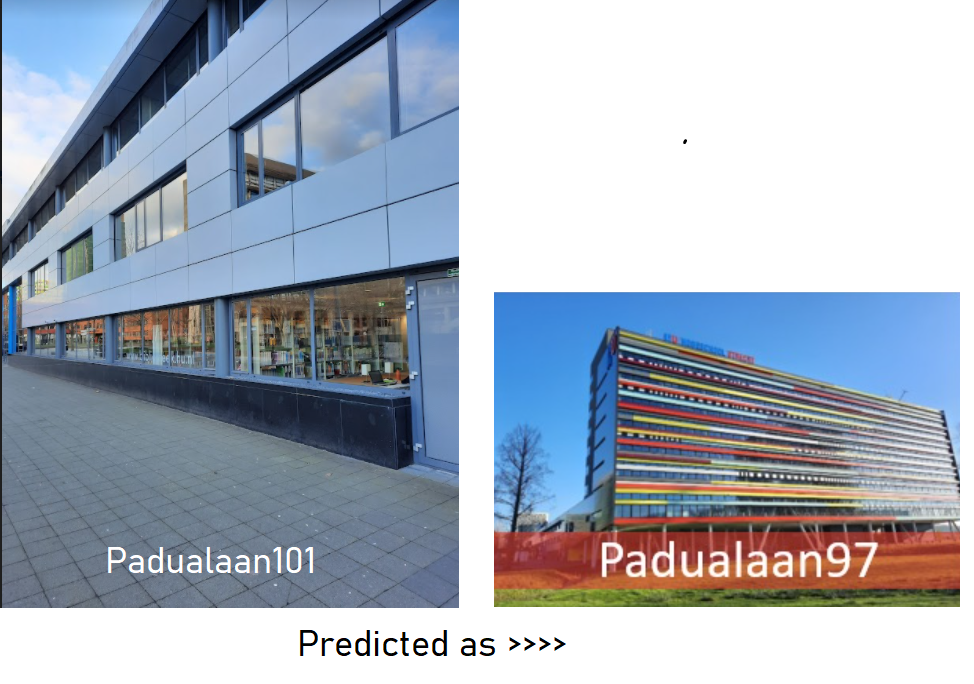

It is the same image that got wrong with our Attempt 5, when we changed the parameters (Shear and Zoom). Out of 60 Test images, only one image was wrongly predicted, having a 97% validation accuracy which is pretty good as shown in the below plots:

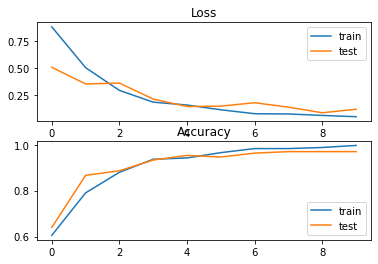

In [ ]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


## Challenges


*   It is very slow to train when using the GPU of Google Colab
*   Even when using the A100 GPUs from Google Cloud, the epoc was still taking around 250sec each, which makes the training long when using more than 20 epocs
*   VGG16 network architecture weights themselves are quite large, around 533MB, which makes it not an easy task in terms of bandwidth and storage. The models and learned weights can be found here [Reference Link](https://www.robots.ox.ac.uk/~vgg/research/very_deep/) 
*   I was not able to use the custom GCE VM option from Google Colab to make use of Google Cloud instance directly, so I had to use their VM and connect Colab to a local runtime, which is not a straight forward task
*   There were irrelevent features in the majority of the trained data (Trees, grass, ..) that caused some prediction issues in Attempts 1,2 and 3












## Conclusion



*   The Convolutional Neural Network VGG16 to make image classification with low number of images achieved very good results (97%) compared to what the model usually achieves (92.7%) using much larger data. [Reference Link](https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918)

*   On a small dataset like ours, overfitting will be the main issue (like what happened in Attempt 3). One way to solve it is data augmentation,  which is a powerful way to fight overfiting when you are working with low number of image data

*   Since we are extracting features of our images dataset using a pretrained model (i.e feature extraction), it proved to be a  valuable technique, especially when working with small image datasets such as our building classes.

*   Training the model (as Attempt 3) with no significant increase in accuracy, nor decrease in loss, for long hours that could could be avoided in the future using keras features (that I did not know about during this project) such as "Earlystopping" to avoid unnecessary utilization of VM instaces. We could have stopped the training after the 15 epoc in Attempt 3, using "EarlyStopping" if there is no increase in any monitored parameter. For instance, we can monitor the validation accuracy by setting patience to 20, which means that the model will stop to train if it doesn’t see any rise in validation accuracy in 20 epochs. Then try to change some parameters and train it again. [Reference Link](https://keras.io/api/callbacks/early_stopping/)

*   Data Augmentation (Horizontal flip, shear and zooming) also proved to enhance the performance (Attempt5) but caused a slightly little more training delay (10sec per epoc when using 20% of shearing and zooming) [Reference Link](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/).

*   Increasing the image dimensions to 224x224 (default) and the batch size significantly enhanced the performance (increased accuracy, decreased loss, and decreased training time significantly) while at the same time using a relatively low epoc number(10 compared to 20,40, and 100).










